In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lightgbm as lgb
import xgboost as xgb

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cluster import DBSCAN

In [5]:
from tpot.builtins import StackingEstimator

In [6]:
from sklearn.cluster import KMeans

In [7]:
filename = "uklon_sample_3_months_dropnan_driver_id.csv"

In [8]:
parse_dates = ['created_at']

In [9]:
df = pd.read_csv(filename, delimiter=",", parse_dates=parse_dates)

/home/temenid/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df.head()

,order_id,ride_id,created_at,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,user_id,driver_id,ride_distance,...,ooExtraCost,ooInitialCost,ooIdleCost,oapAzureMlCost,oapAzureMlCostBid,oapCostProvider,ooSurgeMultiplier,driver_lat,driver_lon,dtTaxiDriver_tdID
0,88314768,764A34A6-5C92-4A0C-90E8-82BDA5A5F9C1,2017-10-31 23:59:59.143,50.448906,30.386448,50.410267,30.412216,420361.0,568114.0,9.10,...,1.0,115.0,0.0,114.0,1.0,AzureML,1.35,50.437012,30.383680,568114.0
1,88314766,299E8328-8BE6-4097-AF81-4834478B4D51,2017-10-31 23:59:58.577,50.446000,30.576200,50.414604,30.384350,722883.0,553135.0,19.74,...,0.0,146.0,0.0,146.0,0.0,AzureML,1.00,50.449512,30.595537,553135.0
2,88314763,4EDC7FB9-5E34-4132-A2B3-B926F81DB439,2017-10-31 23:59:55.050,50.438610,30.459536,50.439339,30.444427,693323.0,568920.0,11.08,...,-7.0,100.0,0.0,107.0,1.0,AzureML,1.09,50.424972,30.458965,568920.0
3,88314762,D0EE9C9A-CFDD-44F8-906D-7C3A7ED65A1C,2017-10-31 23:59:54.420,50.449707,30.515345,50.459896,30.402002,17563.0,527239.0,9.24,...,0.0,88.0,0.0,88.0,0.0,NaN,1.00,50.455327,30.515555,527239.0
4,88314759,18B41EC0-B379-4621-BF7A-DD881D16E038,2017-10-31 23:59:50.053,50.397000,30.632500,50.416607,30.633417,754011.0,531709.0,3.73,...,0.0,55.0,0.0,NaN,NaN,NaN,1.01,NaN,NaN,NaN


In [11]:
df.columns

Index(['order_id', 'ride_id', 'created_at', 'pickup_lat', 'pickup_lon',
       'dropoff_lat', 'dropoff_lon', 'user_id', 'driver_id', 'ride_distance',
       'ooCancelReason', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost',
       'ooExtraCost', 'ooInitialCost', 'ooIdleCost', 'oapAzureMlCost',
       'oapAzureMlCostBid', 'oapCostProvider', 'ooSurgeMultiplier',
       'driver_lat', 'driver_lon', 'dtTaxiDriver_tdID'],
      dtype='object')

In [12]:
df.isnull().sum()

order_id                    0
ride_id                     0
created_at                  0
pickup_lat                565
pickup_lon                565
dropoff_lat               780
dropoff_lon               780
user_id                378190
driver_id                   0
ride_distance               0
ooCancelReason              0
ooSuburbanDistance          0
ooCarSearchTime             0
ooCost                      0
ooExtraCost                 0
ooInitialCost               0
ooIdleCost                  0
oapAzureMlCost        1521212
oapAzureMlCostBid     1521212
oapCostProvider       1350984
ooSurgeMultiplier           0
driver_lat             417486
driver_lon             417486
dtTaxiDriver_tdID      417486
dtype: int64

In [13]:
df.shape

(2815393, 24)

In [14]:
df = df.sample(n=1200000)

In [15]:
df.shape

(1200000, 24)

In [16]:
# Remove rows with missing values in column 'driver_id'. The order was not accepted. there was no trip
new_df = df.dropna(subset=['driver_id','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon'],inplace=False)

In [17]:
# leave only uncanceled ride
new_df = new_df.loc[df['ooCancelReason'] == 0]

In [18]:
new_df.shape

(1010393, 24)

In [19]:
# initialy select the following columns
data = new_df[['created_at','ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon']] # ,'ooIdleCost'

In [20]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
1349695,2017-09-20 09:48:11.920,2.44,0,3,81.0,50.463005,30.480190,50.469868,30.485641
1946014,2017-08-31 14:32:10.157,11.09,0,1,100.0,50.484400,30.592100,50.401200,30.652100
1369000,2017-09-19 18:03:28.987,11.64,0,8,125.0,50.413185,30.635839,50.440018,30.523884
349678,2017-10-21 09:45:53.640,14.91,0,10,150.0,50.442287,30.598545,50.333172,30.559622
671032,2017-10-11 16:02:16.757,3.33,0,64,52.0,50.452682,30.446417,50.439117,30.442051


In [21]:
# count the NaN values in a columns
data.isnull().sum()

created_at            0
ride_distance         0
ooSuburbanDistance    0
ooCarSearchTime       0
ooCost                0
pickup_lat            0
pickup_lon            0
dropoff_lat           0
dropoff_lon           0
dtype: int64

In [22]:
# some simple feature engineering with date
# as categorical
data['quarter'] = data['created_at'].dt.quarter.astype(str)
data['month'] = data['created_at'].dt.month.astype(str)
data['day'] = data['created_at'].dt.day.astype(str)
data['dayofweek'] = data['created_at'].dt.dayofweek.astype(str)
data['hour'] = data['created_at'].dt.hour.astype(str)
data['date'] = data['created_at'].dt.strftime('%Y-%m-%d')

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [23]:
# as categorical
data['quarter_int'] = data['created_at'].dt.quarter.astype(int)
data['month_int'] = data['created_at'].dt.month.astype(int)
data['day_int'] = data['created_at'].dt.day.astype(int)
data['dayofweek_int'] = data['created_at'].dt.dayofweek.astype(int)
data['hour_int'] = data['created_at'].dt.hour.astype(int)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [24]:
dt = {'date': ['2017-08-24', '2017-10-14'], 
        'isHolidays': [1, 1]}
holidays = pd.DataFrame(dt, columns = ['date', 'isHolidays'])

In [25]:
data = pd.merge(data, holidays, on='date', how='left')

In [26]:
data['isHolidays'].fillna(value=0, inplace=True)

In [27]:
data.shape

(1010393, 21)

### Clusterization

In [28]:
pickup_coords = data.loc[:,['pickup_lat','pickup_lon']]
dropoff_coords = data.loc[:,['dropoff_lat','dropoff_lon']]
ride_coords = data.loc[:,['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon']]

In [29]:
num_pickup_clusters = 7
num_dropoff_clusters = 7
num_ride_clusters = 7

In [30]:
pickup_kmeans = KMeans(n_clusters=num_pickup_clusters, random_state=1).fit(pickup_coords)

In [31]:
dropoff_kmeans = KMeans(n_clusters=num_dropoff_clusters, random_state=1).fit(dropoff_coords)

In [32]:
ride_kmeans = KMeans(n_clusters=num_ride_clusters, random_state=1).fit(ride_coords)

In [33]:
id_pickup_label=pickup_kmeans.labels_
id_dropoff_label=dropoff_kmeans.labels_
id_ride_label=ride_kmeans.labels_

In [34]:
id_pickup_label.shape, id_dropoff_label.shape

((1010393,), (1010393,))

In [35]:
data['pickup_cluster'] = id_pickup_label.astype(str)
data['dropoff_cluster'] = id_dropoff_label.astype(str)
data['ride_cluster'] = id_ride_label.astype(str)

In [36]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,quarter,...,date,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,pickup_cluster,dropoff_cluster,ride_cluster
0,2017-09-20 09:48:11.920,2.44,0,3,81.0,50.463005,30.480190,50.469868,30.485641,3,...,2017-09-20,3,9,20,2,9,0.0,2,0,1
1,2017-08-31 14:32:10.157,11.09,0,1,100.0,50.484400,30.592100,50.401200,30.652100,3,...,2017-08-31,3,8,31,3,14,0.0,1,2,6
2,2017-09-19 18:03:28.987,11.64,0,8,125.0,50.413185,30.635839,50.440018,30.523884,3,...,2017-09-19,3,9,19,1,18,0.0,6,4,4
3,2017-10-21 09:45:53.640,14.91,0,10,150.0,50.442287,30.598545,50.333172,30.559622,4,...,2017-10-21,4,10,21,5,9,0.0,1,2,6
4,2017-10-11 16:02:16.757,3.33,0,64,52.0,50.452682,30.446417,50.439117,30.442051,4,...,2017-10-11,4,10,11,2,16,0.0,0,6,2


In [37]:
data.tail()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,quarter,...,date,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,pickup_cluster,dropoff_cluster,ride_cluster
1010388,2017-09-29 07:03:32.867,8.16,0,59,90.0,50.502899,30.492081,50.470196,30.466887,3,...,2017-09-29,3,9,29,4,7,0.0,2,0,1
1010389,2017-08-24 19:16:29.180,14.50,0,67,130.0,50.472130,30.580027,50.441437,30.528309,3,...,2017-08-24,3,8,24,3,19,1.0,1,4,4
1010390,2017-08-03 14:23:58.903,7.69,0,1,68.0,50.484749,30.466902,50.439453,30.505529,3,...,2017-08-03,3,8,3,3,14,0.0,2,4,1
1010391,2017-10-12 17:30:26.557,11.04,0,0,95.0,50.526218,30.610609,50.453316,30.586695,4,...,2017-10-12,4,10,12,3,17,0.0,1,1,6
1010392,2017-09-21 10:43:35.253,3.70,0,11,70.0,50.455574,30.514091,50.451096,30.538111,3,...,2017-09-21,3,9,21,3,10,0.0,3,4,1


In [38]:
data.shape

(1010393, 24)

In [39]:
data.describe()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays
count,1.010393e+06,1010393.0,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06,1.010393e+06
mean,1.104368e+01,0.0,1.912615e+01,1.053507e+02,5.044623e+01,3.051363e+01,5.044617e+01,3.051375e+01,3.361151e+00,9.048621e+00,1.586020e+01,3.008026e+00,1.334108e+01,2.147184e-02
std,7.222302e+00,0.0,3.198120e+01,4.989133e+01,3.858343e-02,8.298587e-02,4.070398e-02,8.875674e-02,4.803343e-01,8.193394e-01,8.867502e+00,1.954544e+00,6.561255e+00,1.449511e-01
min,1.000000e-02,0.0,-3.528000e+03,4.000000e+01,5.010862e+01,2.993005e+01,5.006435e+01,2.988402e+01,3.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.610000e+00,0.0,5.000000e+00,7.000000e+01,5.042295e+01,3.046689e+01,5.042179e+01,3.046431e+01,3.000000e+00,8.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00,0.000000e+00
50%,9.960000e+00,0.0,9.000000e+00,1.000000e+02,5.044257e+01,3.051060e+01,5.044234e+01,3.050883e+01,3.000000e+00,9.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01,0.000000e+00
75%,1.451000e+01,0.0,2.300000e+01,1.250000e+02,5.046571e+01,3.054615e+01,5.046732e+01,3.055311e+01,4.000000e+00,1.000000e+01,2.300000e+01,5.000000e+00,1.900000e+01,0.000000e+00
max,1.389000e+02,0.0,4.243000e+03,1.634000e+03,5.081271e+01,3.098882e+01,5.081271e+01,3.098986e+01,4.000000e+00,1.000000e+01,3.100000e+01,6.000000e+00,2.300000e+01,1.000000e+00


In [40]:
# In our dataset, we have both categorical and numeric data. select them for different processing

In [41]:
# CATEGORICAL (for the moment only these)
catFeatures = ['quarter','month','day','dayofweek', 'pickup_cluster', 'dropoff_cluster','ride_cluster']

In [42]:
# Convert categorical variable into dummy/indicator variables
df_cat = pd.get_dummies(data[catFeatures])

In [43]:
# let's check
df_cat.head()

,quarter_3,quarter_4,month_10,month_8,month_9,day_1,day_10,day_11,day_12,day_13,...,dropoff_cluster_4,dropoff_cluster_5,dropoff_cluster_6,ride_cluster_0,ride_cluster_1,ride_cluster_2,ride_cluster_3,ride_cluster_4,ride_cluster_5,ride_cluster_6
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [44]:
# concat dummy/indicator variables to dataframe
data = pd.concat([data, df_cat], axis=1)

In [45]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,quarter,...,dropoff_cluster_4,dropoff_cluster_5,dropoff_cluster_6,ride_cluster_0,ride_cluster_1,ride_cluster_2,ride_cluster_3,ride_cluster_4,ride_cluster_5,ride_cluster_6
0,2017-09-20 09:48:11.920,2.44,0,3,81.0,50.463005,30.480190,50.469868,30.485641,3,...,0,0,0,0,1,0,0,0,0,0
1,2017-08-31 14:32:10.157,11.09,0,1,100.0,50.484400,30.592100,50.401200,30.652100,3,...,0,0,0,0,0,0,0,0,0,1
2,2017-09-19 18:03:28.987,11.64,0,8,125.0,50.413185,30.635839,50.440018,30.523884,3,...,1,0,0,0,0,0,0,1,0,0
3,2017-10-21 09:45:53.640,14.91,0,10,150.0,50.442287,30.598545,50.333172,30.559622,4,...,0,0,0,0,0,0,0,0,0,1
4,2017-10-11 16:02:16.757,3.33,0,64,52.0,50.452682,30.446417,50.439117,30.442051,4,...,0,0,1,0,0,1,0,0,0,0


In [46]:
# drop useless categorical column (because we have dummy/indicator variables)
data.drop(catFeatures, axis=1,inplace=True)

In [47]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,hour,...,dropoff_cluster_4,dropoff_cluster_5,dropoff_cluster_6,ride_cluster_0,ride_cluster_1,ride_cluster_2,ride_cluster_3,ride_cluster_4,ride_cluster_5,ride_cluster_6
0,2017-09-20 09:48:11.920,2.44,0,3,81.0,50.463005,30.480190,50.469868,30.485641,9,...,0,0,0,0,1,0,0,0,0,0
1,2017-08-31 14:32:10.157,11.09,0,1,100.0,50.484400,30.592100,50.401200,30.652100,14,...,0,0,0,0,0,0,0,0,0,1
2,2017-09-19 18:03:28.987,11.64,0,8,125.0,50.413185,30.635839,50.440018,30.523884,18,...,1,0,0,0,0,0,0,1,0,0
3,2017-10-21 09:45:53.640,14.91,0,10,150.0,50.442287,30.598545,50.333172,30.559622,9,...,0,0,0,0,0,0,0,0,0,1
4,2017-10-11 16:02:16.757,3.33,0,64,52.0,50.452682,30.446417,50.439117,30.442051,16,...,0,0,1,0,0,1,0,0,0,0


In [48]:
#INTEGER
intFeatures = ['ride_distance','ooSuburbanDistance','ooCarSearchTime','quarter_int','month_int','day_int','dayofweek_int']

In [49]:
# integer features scaling
scaler = MinMaxScaler()
data[intFeatures] = scaler.fit_transform(data[intFeatures])

In [50]:
# split features and target
dfX = data.drop(['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon','created_at','date','ooCost'], axis=1)
dfY = data['ooCost']

In [51]:
dfX.head()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,hour,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,...,dropoff_cluster_4,dropoff_cluster_5,dropoff_cluster_6,ride_cluster_0,ride_cluster_1,ride_cluster_2,ride_cluster_3,ride_cluster_4,ride_cluster_5,ride_cluster_6
0,0.017496,0.0,0.454382,9,0.0,0.5,0.633333,0.333333,9,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.079775,0.0,0.454124,14,0.0,0.0,1.000000,0.500000,14,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0.083735,0.0,0.455025,18,0.0,0.5,0.600000,0.166667,18,0.0,...,1,0,0,0,0,0,0,1,0,0
3,0.107279,0.0,0.455282,9,1.0,1.0,0.666667,0.833333,9,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.023904,0.0,0.462231,16,1.0,1.0,0.333333,0.333333,16,0.0,...,0,0,1,0,0,1,0,0,0,0


In [52]:
dfY.head()

0     81.0
1    100.0
2    125.0
3    150.0
4     52.0
Name: ooCost, dtype: float64

In [53]:
# get features names
fNames = dfX.columns

In [54]:
fNames

Index(['ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime', 'hour',
       'quarter_int', 'month_int', 'day_int', 'dayofweek_int', 'hour_int',
       'isHolidays', 'quarter_3', 'quarter_4', 'month_10', 'month_8',
       'month_9', 'day_1', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'day_29', 'day_3', 'day_30', 'day_31', 'day_4', 'day_5',
       'day_6', 'day_7', 'day_8', 'day_9', 'dayofweek_0', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'pickup_cluster_0', 'pickup_cluster_1',
       'pickup_cluster_2', 'pickup_cluster_3', 'pickup_cluster_4',
       'pickup_cluster_5', 'pickup_cluster_6', 'dropoff_cluster_0',
       'dropoff_cluster_1', 'dropoff_cluster_2', 'dropoff_cluster_3',
       'dropoff_cluster_4', 'dropoff_cluster_5', 'dropoff_cluster_6',
 

In [55]:
# Get values
# features
X = dfX[fNames].values
# targets
y = dfY.values

In [56]:
X.shape, y.shape

((1010393, 74), (1010393,))

In [57]:
# Split our data into random train and test subsets with specific proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [58]:
X_train.shape, y_train.shape

((757794, 74), (757794,))

### simple linear regression

In [59]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [60]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [61]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [62]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 335.09


In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
mean_absolute_percentage_error(y_test, y_pred)

10.800459367255831

### RandomForestRegressor

In [65]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [66]:
# Make predictions using the testing set
y_pred = rf.predict(X_test)

In [67]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 316.73


In [68]:
mean_absolute_percentage_error(y_test, y_pred)

10.475150734104792

### xgboost

In [69]:
xgb_model = xgb.XGBRegressor(random_state=1)

In [70]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [71]:
y_pred = xgb_model.predict(X_test)

In [72]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 318.69


In [73]:
mean_absolute_percentage_error(y_test, y_pred)

10.564434589228956

### LightGBM

In [74]:
lgb_model = lgb.LGBMRegressor(objective='mape',n_estimators=400, learning_rate=0.2, num_leaves=75, random_state=1)

In [75]:
lgb_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
       n_jobs=-1, num_leaves=75, objective='mape', random_state=1,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [76]:
y_pred = lgb_model.predict(X_test)

In [77]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 360.48


In [78]:
mean_absolute_percentage_error(y_test, y_pred)

7.959195226420274

In [79]:
feature_importances = lgb_model.feature_importances_

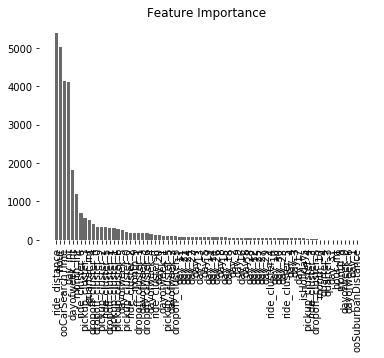

In [80]:
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Create plot
plt.figure()
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(fNames)), feature_importances[indices], color = 'dimgray')

# Add feature names as x-axis labels
plt.xticks(range(len(fNames)), fNames[indices], rotation=90)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.show()

In [81]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(fNames, feature_importances):
    feats[feature] = importance #add the name/value pair 

# create DataFrame
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature importances'})

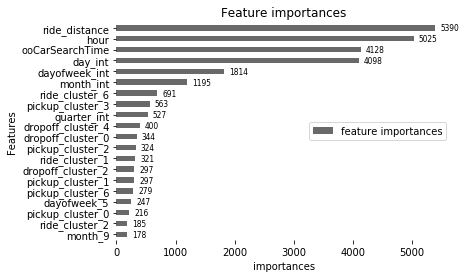

In [82]:
ax = importances.sort_values(by='feature importances').tail(20).plot(kind='barh', color = 'dimgray')

for p in ax.patches:
    ax.annotate(
        str(int(p.get_width())),
        (p.get_x() + p.get_width(), p.get_y()),
        xytext=(5,0),
        textcoords='offset points',
        horizontalalignment='left',
        fontsize=7.5
)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.title('Feature importances')
plt.xlabel('importances')
plt.ylabel('Features')
plt.legend(loc="center right")
plt.show()

### ExtraTreesRegressor

In [83]:
etr = ExtraTreesRegressor(random_state=1)

In [84]:
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

In [85]:
y_pred = etr.predict(X_test)

In [86]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 376.46


In [87]:
mean_absolute_percentage_error(y_test, y_pred)

11.007344745254406